In [1]:
import sys

sys.path.append("..")

In [2]:
import jax

# if not jax._src.xla_bridge.backends_are_initialized():
#     jax.config.update("jax_num_cpu_devices", 8)
# print(f"You have 8 “fake” JAX devices now: {jax.devices()}")


In [3]:
import jax.numpy as jnp
from flax import nnx
from jax.sharding import AxisType
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

from src.modules.lstm import (
    LSTMForecaster,
    LSTMForecasterConfig,
    LSTMForecasterShardings,
)

from src.utils.viz import plot_forecast
import random


In [4]:
config = LSTMForecasterConfig(
    hidden_features=16,
    num_metrics=3,
    head_bias=True,
    horizon=10,
    num_heads=4,
)

shardings = LSTMForecasterShardings()
mesh = jax.make_mesh(
    (1, 1),
    ("dp", "tp"),
    axis_types=(AxisType.Auto, AxisType.Auto),
)


rngs = nnx.Rngs(123)


jax.set_mesh(mesh)

In [5]:
with jax.set_mesh(mesh):
    model = LSTMForecaster(
        config=config,
        shardings=shardings,
        rngs=rngs,
        dtype=jnp.float32,
        param_dtype=jnp.float32,
    )

In [6]:
nnx.display(model)

In [7]:
model.rnn.cell.dense_i.kernel[0, 0]

Array(-0.55811375, dtype=float32)

In [8]:
batch = 5
num_devices = 6
timesteps = 16

input = jax.random.normal(
    rngs(),
    shape=(batch, num_devices, config.num_metrics, timesteps),
)

In [9]:
# Split input into context (first half) and ground truth (second half)
context = input[:, :, :, : timesteps // 2]
ground_truth = input[:, :, :, timesteps // 2 :]

print(f"Context shape: {context.shape}")
print(f"Ground truth shape: {ground_truth.shape}")

Context shape: (5, 6, 3, 8)
Ground truth shape: (5, 6, 3, 8)


In [10]:
# Run autoregressive forecasting for 8 steps
forecasts = model(context)

print(f"Forecasts shape: {forecasts.point_predictions.shape}")

Forecasts shape: (5, 6, 3, 10)


<Axes: title={'center': 'Forecast for Device 5, Metric 2'}, xlabel='Time Step', ylabel='Value'>

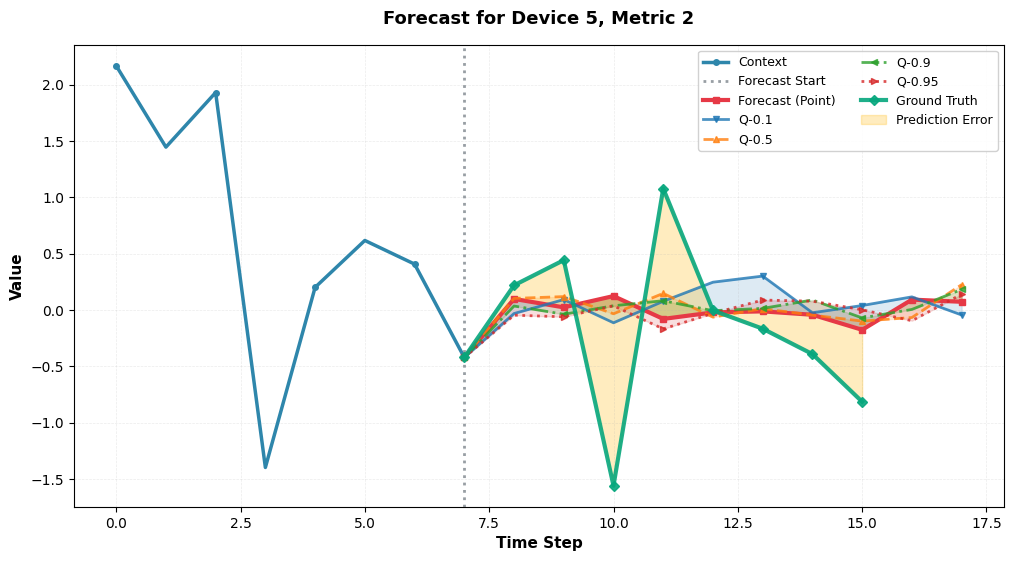

In [15]:
batch, devices, metrics, _ = context.shape

batch_id = random.randint(0, batch - 1)
metric_id, device_id = random.randint(0, metrics - 1), random.randint(0, devices - 1)

# Select specific batch, device, and metric for visualization
t_context = context[batch_id, device_id, metric_id, :]
t_forecast = forecasts.point_predictions[batch_id, device_id, metric_id, :]
t_quantiles = forecasts.quantile_predictions[:, batch_id, device_id, metric_id, :]
t_ground_truth = ground_truth[batch_id, device_id, metric_id, :]


fig, ax = plt.subplots(figsize=(12, 6))
plot_forecast(
    context=t_context,
    forecasts=t_forecast,
    quantile_forecasts=t_quantiles,
    quantiles=config.quantiles,
    ground_truth=t_ground_truth,
    ax=ax,
    title=f"Forecast for Device {device_id}, Metric {metric_id}",
)

In [12]:
with io.BytesIO() as buffer:
    fig.savefig(buffer, format="png", bbox_inches="tight")
    buffer.seek(0)
    img = np.array(Image.open(buffer).convert("RGB"))
img.shape

(561, 1013, 3)

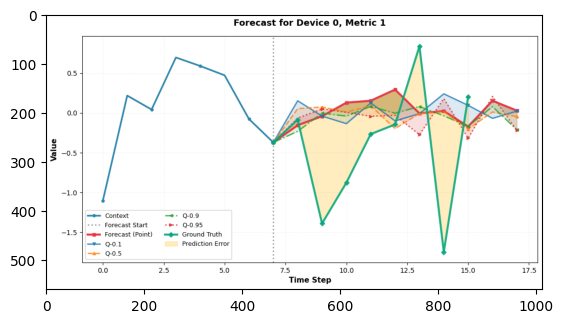

In [13]:
plt.imshow(img)